# Sentiment agent model analysis

A small notebook to test and compare the sentiment agent model.

Written by Luc Bijl.

In [1]:
import pandas as pd
time_start = pd.to_datetime('2023-10-07 00:00:00')
time_end = pd.to_datetime('2023-10-07 16:00:00')

In [2]:
import_posts = '../datasets/israel-case/scored/israel-scored.csv'
df_posts = pd.read_csv(import_posts)
df_posts['date'] = pd.to_datetime(df_posts['date'])

df_posts_date = df_posts.set_index('date').sort_index()
len(df_posts_date)

10933

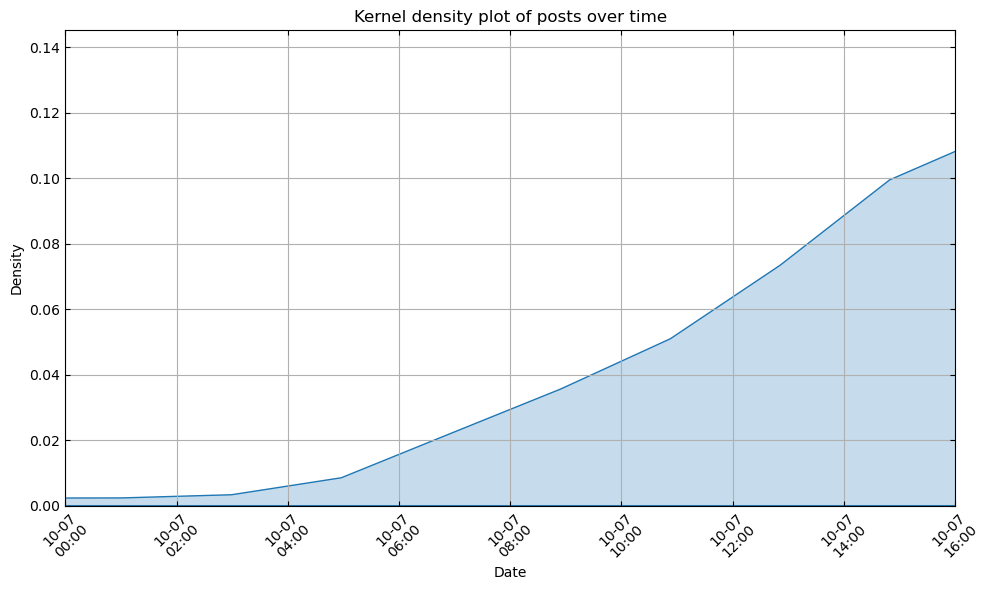

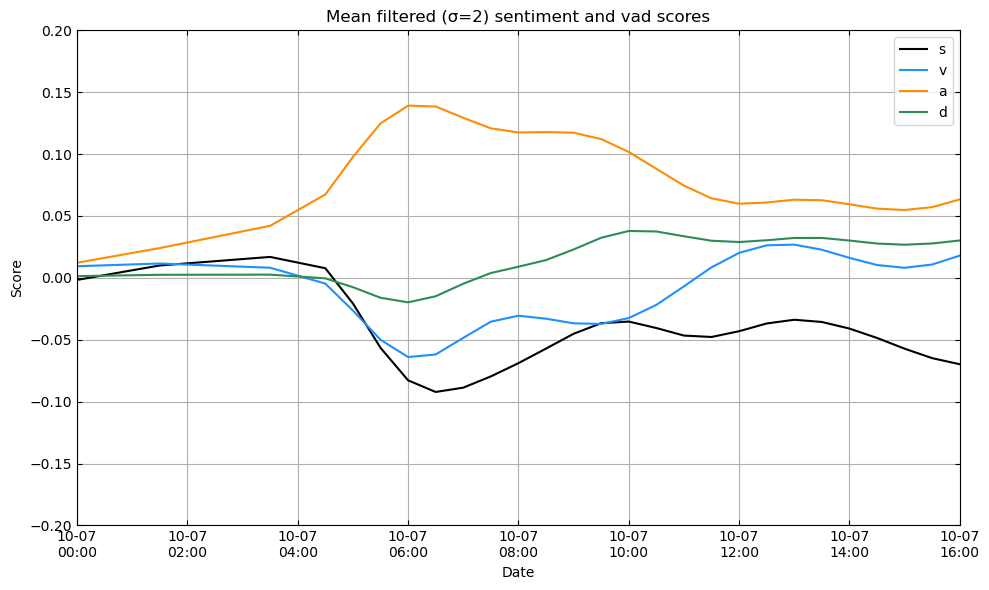

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

plt.figure(figsize=(10,6))

sns.kdeplot(data=df_posts_date.index, shade=True, bw_adjust=0.1)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(time_start, time_end)

plt.xlabel('Date')
plt.title('Kernel density plot of posts over time')

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

##################################

from scipy.ndimage import gaussian_filter1d

resample_period = '30min'
sigma = 2

posts_resampled = {'s': [], 'v': [], 'a': [], 'd': []}
smoothed_scores = {'s': [], 'v': [], 'a': [], 'd': []}

for i in ['s', 'v', 'a', 'd']:
    posts_resampled[i] = df_posts_date[i].resample(resample_period).mean().dropna()
    smoothed_scores[i] = gaussian_filter1d(posts_resampled[i], sigma=sigma)

plt.figure(figsize=(10,6))

for i,j in zip(['s', 'v', 'a', 'd'], ['black', 'dodgerblue', 'darkorange', 'seagreen']):
    plt.plot(posts_resampled[i].index, smoothed_scores[i], label=i, color=j)

plt.ylim(-0.2, 0.2)
plt.xlim(time_start, time_end)

plt.title(f'Mean filtered (σ={sigma}) sentiment and vad scores')
plt.xlabel('Date')
plt.ylabel('Score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

In [17]:
from scripts.sentiment_agent_model import sentiment_agent_model
import pandas as pd

import_posts = '../datasets/israel-case/scored/israel-scored.csv'
cardinality_S = 30
string_start = '2023-10-07 6:15'
string_end = '2023-10-07 16:00'
post_period = 60
string_threshold = '5d'

params = {}
params['sp'] = {'age': 0.1, 
                's': [[0.4, 1.5, 1], [0.6, -1.5, -1]],
                'v': [[0.4, 1.5, 1], [0.6, -1.5, -1]],
                'a': [[1, 2, 0]],
                'd': [[1, 0.5, 0]]}
params['cif'] = [[1, -1.5, 3]]
params['pp'] = {'s': [[0.8, 7, 0.05], [0.8, -7, -0.05]],
                'v': [[0.8, 7, 0.05], [0.8, -7, -0.05]],
                'a': [[1, 2, -1]],
                'd': [[0.8, 7, 0.05], [0.8, -7, -0.05]]}

df_model_posts = sentiment_agent_model(import_posts, cardinality_S, string_start, string_end, string_threshold, post_period, params)

df_model_posts['date'] = pd.to_datetime(df_model_posts['date'])
df_posts_model_date = df_model_posts.set_index('date').sort_index()

47


100%|██████████| 586/586 [00:18<00:00, 30.89it/s]


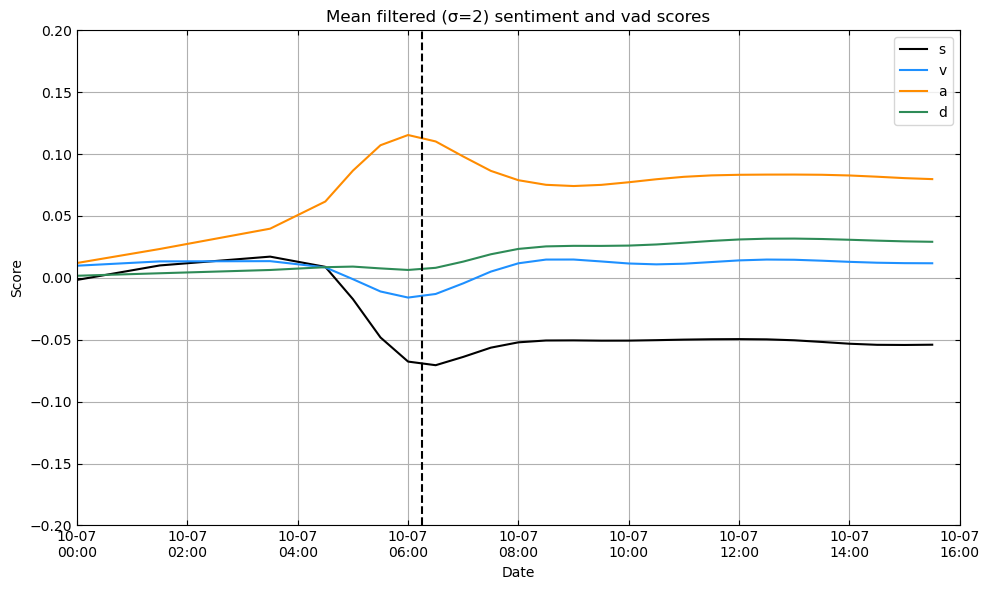

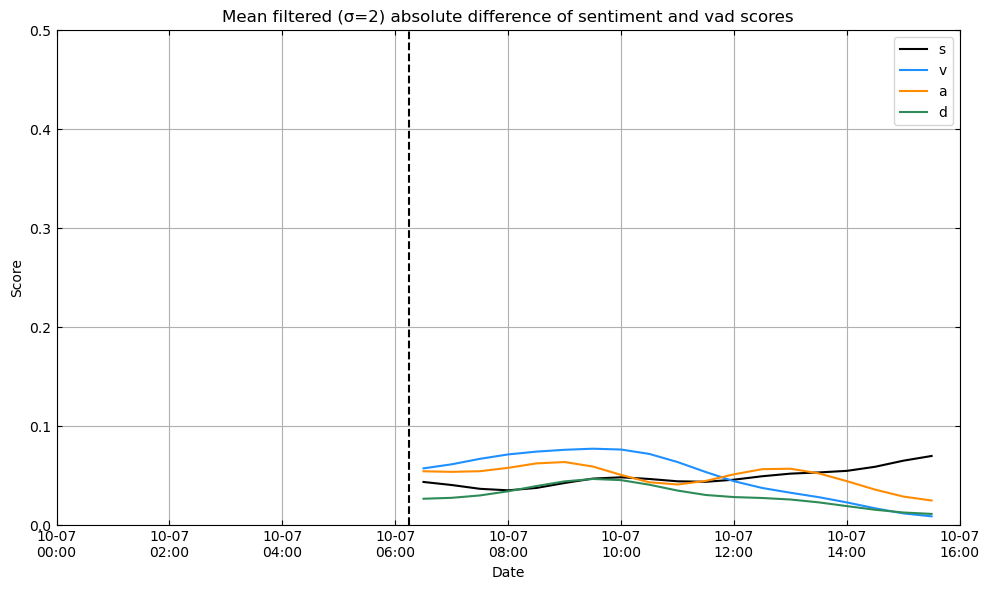

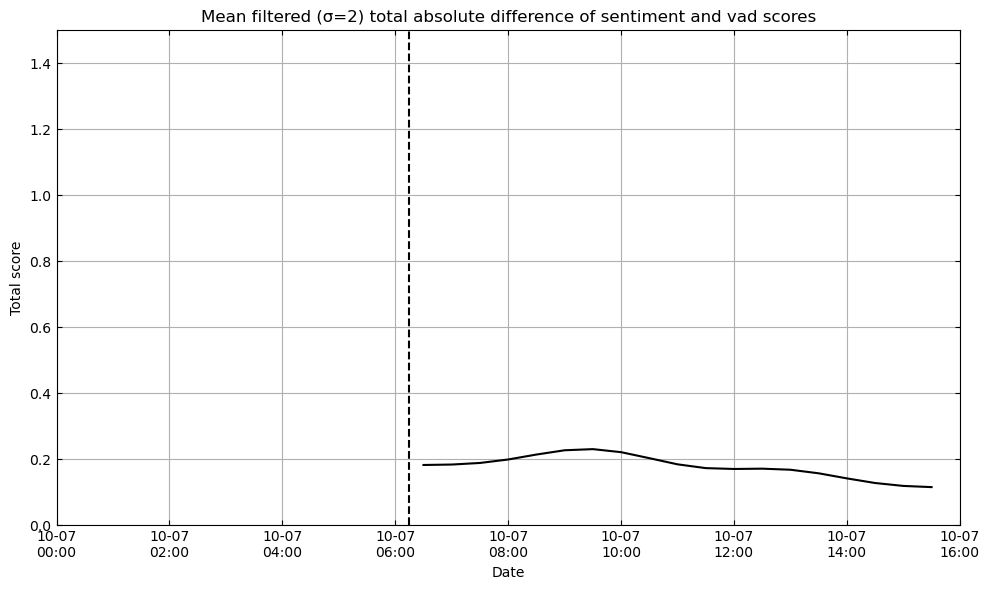

In [18]:
posts_model_resampled = {'s': [], 'v': [], 'a': [], 'd': []}
model_smoothed_scores = {'s': [], 'v': [], 'a': [], 'd': []}

for i in ['s', 'v', 'a', 'd']:
    posts_model_resampled[i] = df_posts_model_date[i].resample(resample_period).mean().dropna()
    model_smoothed_scores[i] = gaussian_filter1d(posts_model_resampled[i], sigma=sigma)

plt.figure(figsize=(10,6))

for i,j in zip(['s', 'v', 'a', 'd'], ['black', 'dodgerblue', 'darkorange', 'seagreen']):
    plt.plot(posts_model_resampled[i].index, model_smoothed_scores[i], label=i, color=j)

plt.ylim(-0.2, 0.2)
plt.xlim(time_start, time_end)

plt.title(f'Mean filtered (σ={sigma}) sentiment and vad scores')
plt.xlabel('Date')
plt.ylabel('Score')
plt.grid(True)

plt.axvline(pd.to_datetime(string_start), color='black', linestyle='--')
plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

######################

posts_diff_resampled = abs(pd.DataFrame(posts_model_resampled).loc[string_start:string_end] - pd.DataFrame(posts_resampled).loc[string_start:string_end])
posts_diff_resampled.dropna(inplace=True)

diff_smoothed_scores = {'s': [], 'v': [], 'a': [], 'd': []}

for i in ['s', 'v', 'a', 'd']:
    diff_smoothed_scores[i] = gaussian_filter1d(posts_diff_resampled[i], sigma=sigma)

plt.figure(figsize=(10,6))

for i,j in zip(['s', 'v', 'a', 'd'], ['black', 'dodgerblue', 'darkorange', 'seagreen']):
    plt.plot(posts_diff_resampled[i].index, diff_smoothed_scores[i], label=i, color=j)

plt.ylim(0, 0.5)
plt.xlim(time_start, time_end)

plt.title(f'Mean filtered (σ={sigma}) absolute difference of sentiment and vad scores')
plt.xlabel('Date')
plt.ylabel('Score')
plt.grid(True)

plt.axvline(pd.to_datetime(string_start), color='black', linestyle='--')
plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

######################

total_diff_resampled = posts_diff_resampled['s'] + posts_diff_resampled['v'] + posts_diff_resampled['a'] + posts_diff_resampled['d']
total_diff_smoothed_scores = gaussian_filter1d(total_diff_resampled, sigma=sigma)

plt.figure(figsize=(10,6))

plt.plot(total_diff_resampled.index, total_diff_smoothed_scores, color='black')

plt.ylim(0, 1.5)
plt.xlim(time_start, time_end)

plt.title(f'Mean filtered (σ={sigma}) total absolute difference of sentiment and vad scores')
plt.xlabel('Date')
plt.ylabel('Total score')
plt.grid(True)

plt.axvline(pd.to_datetime(string_start), color='black', linestyle='--')
plt.tick_params(axis='both', direction='in',top=True, right=True)

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()